# Strategy Evaluation

In [1]:
!pip install -q evaluate
!pip install -q transformers
!pip install -q rouge_score
!pip install -q bert_score


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os 

import pandas as pd

import matplotlib.pyplot as plt

from evaluate import load

from transformers import BartTokenizer, BartForConditionalGeneration

In [3]:
# change working directory to root
os.chdir('../')
os.getcwd()

'/opt/app-root/src/ask_project_nexodus_docs'

In [4]:
# load test_df
test_df = pd.read_csv('data/results/test_df.csv', index_col=0)

display(test_df.head())
display(test_df.shape)

,questions,answers,generated_answers,extracted_answers,abstracted_answers,pretrained_answers,finetuned_answers
1,How would you add a static IP to a Linux machine?,You can add a static IP to a Linux machine by ...,"To add a static IP to a Linux machine, you wil...",this guide will walk you through getting your ...,sudo ip link del wg0 osxwindows,"In Linux's linux framework, setting up an IP a...",Answer: You would add a static IP to a Linux m...
2,What is WireGuard?,WireGuard is an open-source VPN solution that ...,WireGuard is a software application that prote...,relay node the relay needs to have v6 forwardi...,tunneling mode,wireguards,Answer: WireGuard is the name of several progr...
14,What is the purpose of the `/etc/resolv.conf` ...,The `/etc/resolv.conf` file is used to configu...,The /etc/resolv.conf file in Linux is used to ...,in conclusion in the short term since we are n...,cross organization device sharing,To store a copy of the resolution of the kerne...,Answer: The /etc/resolv.conf file is used to s...
20,What is the purpose of the `ip` command in Linux?,The `ip` command is a powerful tool for manipu...,The ip command in Linux is used to connect to ...,ipprotocol ipv4 proto frompor...,starting port range,the process to synchronize a remote directory,Answer: The ip command is used to configure pa...
21,How would you add a static IP to a Linux machine?,You can add a static IP to a Linux machine by ...,"To add a static IP to a Linux machine, you wil...",this guide will walk you through getting your ...,sudo ip link del wg0 osxwindows,"To do this, you'd first need to add an etherne...",Answer: You would add a static IP to a Linux m...


(20, 7)

In [5]:
# convert columns to lists
answers = list(test_df["answers"])
pretrained_answers = list(test_df["pretrained_answers"])
finetuned_answers = list(test_df["finetuned_answers"])
extracted_answers = list(test_df["extracted_answers"])
abstracted_answers = list(test_df["abstracted_answers"])

## Word Error Rate (WER)
WER = (S + D + I) / N = (S + D + I) / (S + D + C)

- S is the number of substitutions,

- D is the number of deletions,

- I is the number of insertions,

- C is the number of correct words,

- N is the number of words in the reference (N=S+D+C).

In [6]:
# code from adapted from [1]
wer = load("wer")
def calc_wer(predictions, references):
    wer_score = wer.compute(predictions=predictions, 
                            references=references)
    return wer_score

In [7]:
pretrained_wer = calc_wer(pretrained_answers, answers)
finetuned_wer = calc_wer(finetuned_answers, answers)
extracted_wer = calc_wer(extracted_answers, answers)
abstracted_wer = calc_wer(abstracted_answers, answers)

## Recall-Oriented Understudy for Gisting Evaluation (ROUGE)

Calculates overlap of ngrams between prediction and reference. 

- ROUGE-1 recall is num matches/num words in reference

- ROUGE-1 precision is num matches/num words in prediction

- ROUGE-1 F1-Score is 2(recall * precision / recall + precision)

In [9]:
# code from adapted from [2]
rouge = load('rouge')
def calc_rouge(predictions, references):
    results = rouge.compute(predictions=predictions,
                            references=references,
                            use_aggregator=True)
    return results["rouge1"]

In [10]:
pretrained_rouge = calc_rouge(pretrained_answers, answers)
finetuned_rouge = calc_rouge(finetuned_answers, answers)
extracted_rouge = calc_rouge(extracted_answers, answers)
abstracted_rouge = calc_rouge(abstracted_answers, answers)

## BertScore

Computes a cosine similarity score for each token in the predicted sentence with each token in the reference sentence.

In [11]:
# code from adapted from [3]
bertscore = load("bertscore")
def BERTScore(predictions, references):
    results = bertscore.compute(predictions=predictions, 
                                references=references, 
                                model_type="distilbert-base-uncased")
    mean_precision = sum(results['precision']) / len(results['precision'])
    mean_recall = sum(results['recall']) / len(results['recall'])
    return mean_precision, mean_recall

In [12]:
finetuned_precision, finetuned_recall = BERTScore(finetuned_answers, answers)
pretrained_precision, pretrained_recall = BERTScore(pretrained_answers, answers)
extracted_precision, extracted_recall = BERTScore(extracted_answers, answers)
abstracted_precision, abstracted_recall = BERTScore(abstracted_answers, answers)

## Plot Evaluation Metrics

In [13]:
def create_eval_dict(extracted_error, abstracted_error, pretrained_error, finetuned_error):
    eval_dict =  {'Extractive': extracted_error, 'Abstractive': abstracted_error, 'Pretrained':pretrained_error, 'Finetuned': finetuned_error}
    return eval_dict

In [14]:
wer_dict = create_eval_dict(extracted_wer, abstracted_wer, pretrained_wer, finetuned_wer)
rouge_dict = create_eval_dict(extracted_rouge, abstracted_rouge, pretrained_rouge, finetuned_rouge)
precision_dict = create_eval_dict(extracted_precision, abstracted_precision, pretrained_precision, finetuned_precision)
recall_dict = create_eval_dict(extracted_recall, abstracted_recall, pretrained_recall, finetuned_recall)

In [15]:
def plot_eval_metrics(eval_dict, title, xlabel, ylabel, color):
    fig = plt.figure(figsize=(5,5))
    x, y = list(eval_dict.keys()), list(eval_dict.values())
    plt.bar(x, y, color=color, width=0.4)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

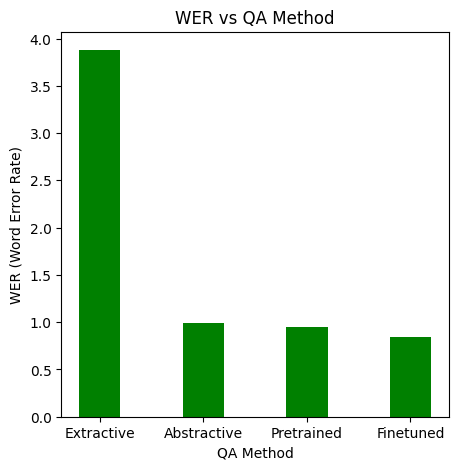

In [16]:
plot_eval_metrics(wer_dict, 'WER vs QA Method', xlabel='QA Method', ylabel='WER (Word Error Rate)', color='green')

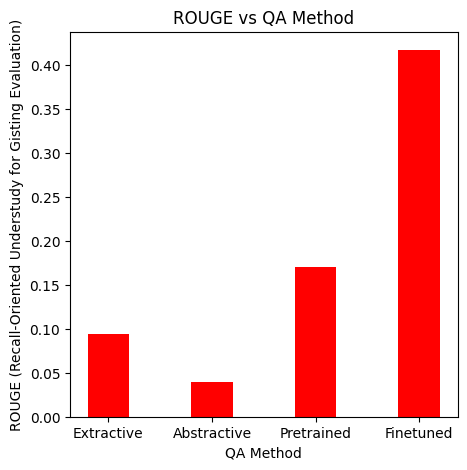

In [17]:
plot_eval_metrics(rouge_dict, 'ROUGE vs QA Method', xlabel='QA Method', ylabel='ROUGE (Recall-Oriented Understudy for Gisting Evaluation)', color='red')

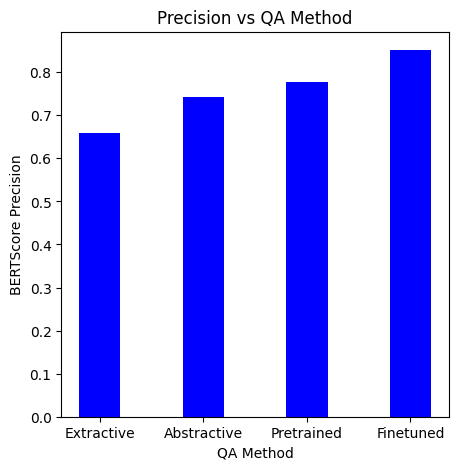

In [18]:
plot_eval_metrics(precision_dict, 'Precision vs QA Method', xlabel='QA Method', ylabel='BERTScore Precision', color='blue')

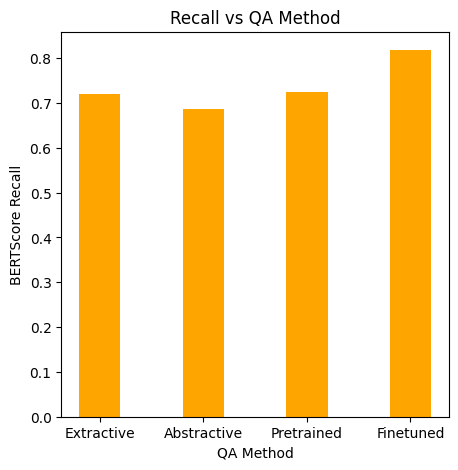

In [19]:
plot_eval_metrics(recall_dict, 'Recall vs QA Method', xlabel='QA Method', ylabel='BERTScore Recall', color='orange')

## Citations
1. https://huggingface.co/spaces/evaluate-metric/wer
2. https://huggingface.co/spaces/evaluate-metric/rouge
3. https://huggingface.co/spaces/evaluate-metric/bertscore